In [ ]:
!pip install -r requirements.txt

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
    
import matplotlib.pyplot as plt
from copy import deepcopy


In [2]:
data_path = "data/1month_anomaly_Global_ea_2t_201907_1991-2020_v02.grib"
original_data = xr.open_dataset(data_path, engine="cfgrib")

original_data

<xarray.Dataset> Size: 4MB
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] 8B ...
Data variables:
    t2m         (latitude, longitude) float32 4MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-04T10:22 GRIB to CDM+CF via cfgrib-0.9.1...

# Mercator projection

The Mercator projection is a conformal cylindrical map projection first presented by Flemish geographer and mapmaker Gerardus Mercator in 1569. In the 18th century, it became the standard map projection for navigation due to its property of representing rhumb lines as straight lines. 


![alt text](<Screenshot from 2024-12-04 09-55-55.png>)


 ![alt text](<Screenshot from 2024-12-04 09-59-26.png>)

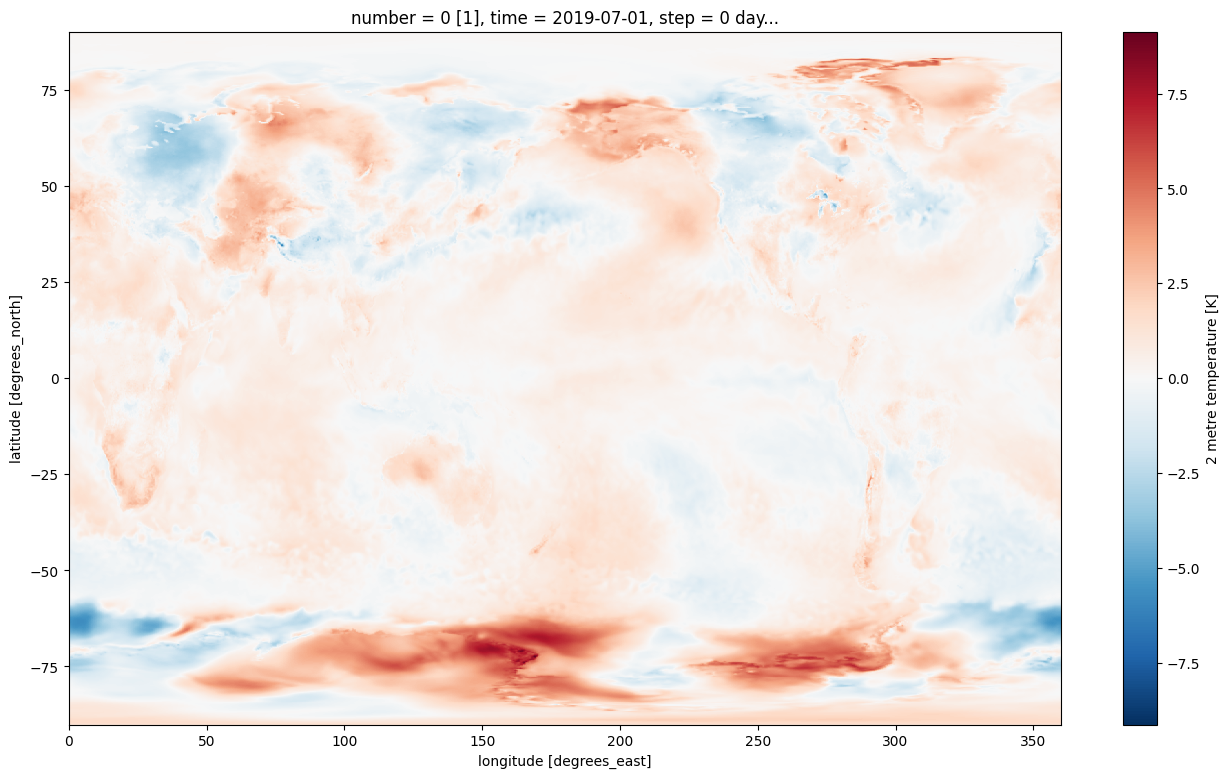

In [3]:
original_data["t2m"].plot(figsize=(16,9))

> First we specify Coordinate Reference System (CRS) for Map Projection
> We will use Mercator, which is a cylindrical, conformal projection. 
- It has very large distortion at high latitudes, cannot fully reach the polar regions.

In [4]:
projection = ccrs.Mercator()

Specify CRS, that will be used to tell the code, where should our data be plotted

In [5]:
crs = ccrs.PlateCarree()

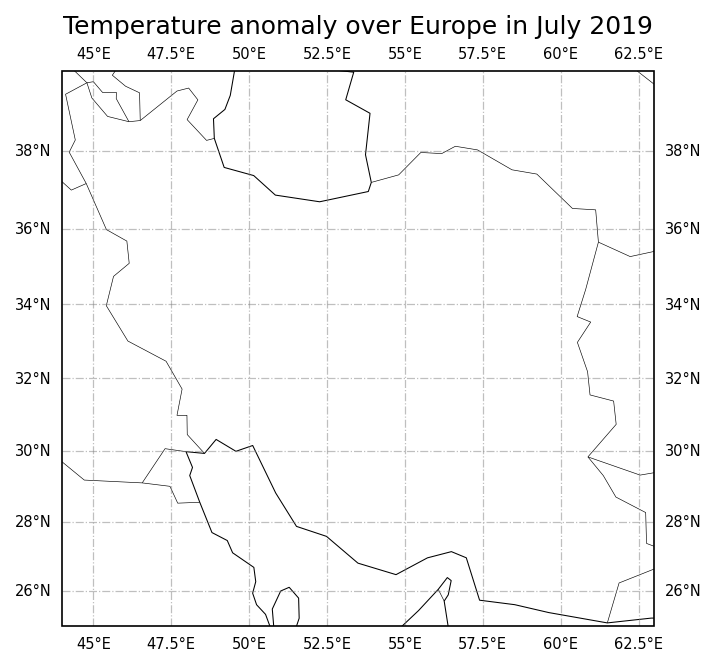

In [6]:
# create axes for the specific projection 
plt.figure(dpi=150)
ax = plt.axes(projection=projection, frameon=True)

# Draw gridlines in degrees over Mercator map
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=.6, color='gray', alpha=0.5, linestyle='-.')

gl.xlabel_style = {"size" : 7}
gl.ylabel_style = {"size" : 7}

# plot borders and coastlines, we can use cartopy feature
ax.add_feature(cf.COASTLINE.with_scale("110m"), lw=0.5) 
ax.add_feature(cf.BORDERS.with_scale("110m"), lw=0.3) 

# specify extent of our map in minimum/maximum longitude/latitude
# Note that these values are specified in degrees of longitude and degrees of latitude
# However, we can specify them in any crs that we want, but we need to provide appropriate
# crs argument in ax.set_extent

# Defines the longitudinal range (west to east).
lon_min = 44
lon_max = 63

# Defines the latitudinal range (south to north).
lat_min = 25
lat_max = 40

# crs is PlateCarree -> we are explicitly telling axes, that we are creating bounds that are in degrees
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
plt.title(f"Temperature anomaly over Europe in {original_data.valid_time.dt.strftime('%B %Y').values}")
plt.show()

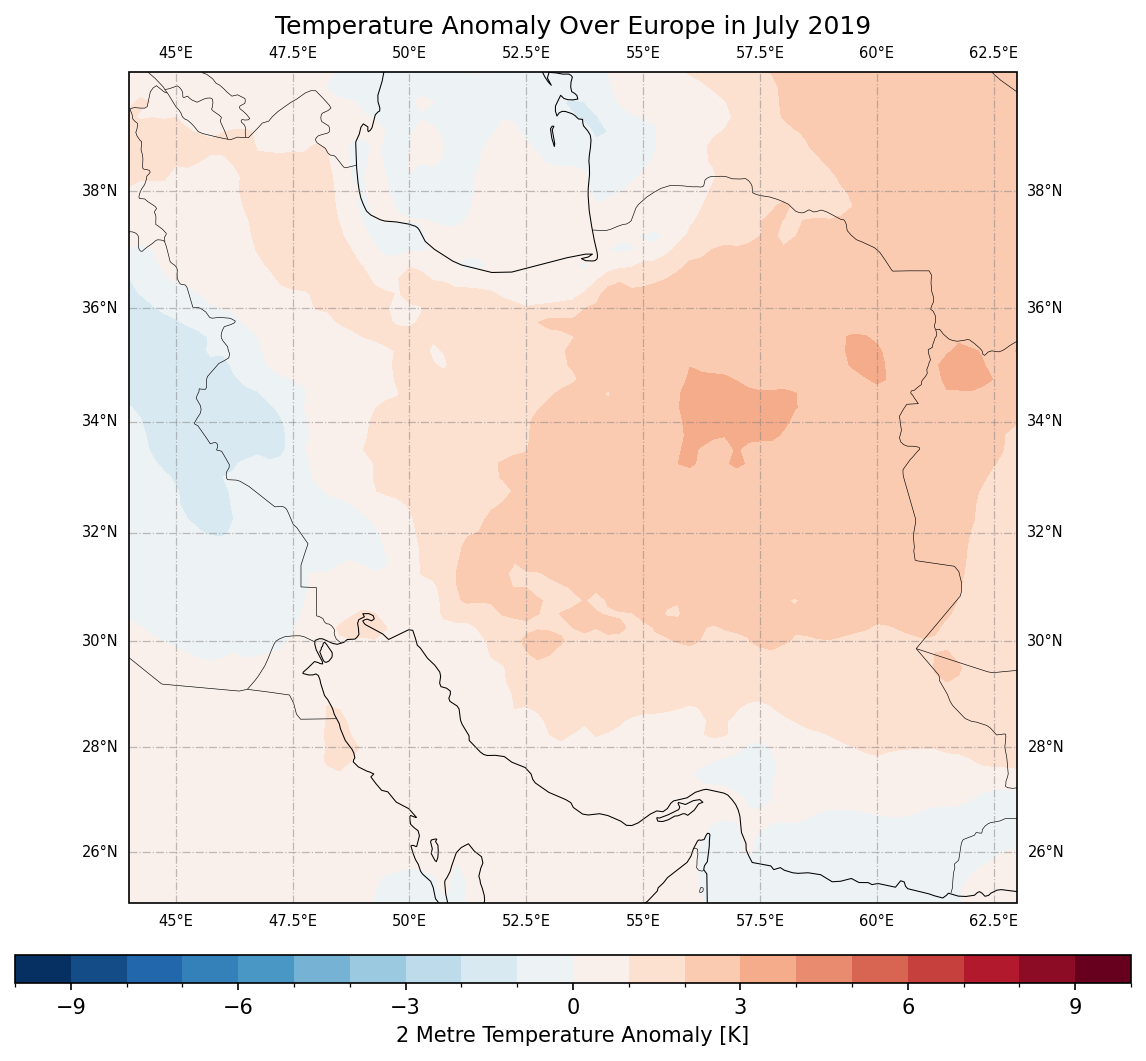

In [7]:
# Set default figure background to white
plt.rcParams['figure.facecolor'] = 'white'

# Function to plot a dataset on a Mercator map
def plot_dataset(dataset: xr.Dataset):
    """
    Plot temperature anomaly data on a Mercator projection map.

    Parameters:
        dataset (xr.Dataset): The dataset containing 't2m' data and 'valid_time'.
    """

    # Define the map projection (Mercator) for visualization
    projection = ccrs.Mercator()

    # CRS of the dataset (PlateCarree assumes data is in lat/lon)
    data_crs = ccrs.PlateCarree()

    # Create a figure and map axes using the Mercator projection
    plt.figure(figsize=(16, 9), dpi=150)
    ax = plt.axes(projection=projection)

    # Add gridlines (latitude and longitude lines) to the map
    gridlines = ax.gridlines(
        crs=data_crs, draw_labels=True,
        linewidth=0.6, color='gray', alpha=0.5, linestyle='-.'
    )
    gridlines.xlabel_style = {"size": 7}
    gridlines.ylabel_style = {"size": 7}

    # Add geographical features: coastlines and country borders
    ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

    # Define the geographic extent of the map (Europe region)
    # lon_min, lon_max = -20, 45
    # lat_min, lat_max = 34, 60

    lon_min = 44
    lon_max = 63

    # Defines the latitudinal range (south to north).
    lat_min = 25
    lat_max = 40
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=data_crs)

    # Plot the temperature anomaly ('t2m') data on the map
    cbar_kwargs = {
        'orientation': 'horizontal', 'shrink': 0.6, "pad": 0.05,
        'aspect': 40, 'label': '2 Metre Temperature Anomaly [K]'
    }
    dataset["t2m"].plot.contourf(
        ax=ax, transform=data_crs, cbar_kwargs=cbar_kwargs, levels=21
    )

    # Add a title with the time information from the dataset
    plt.title(f"Temperature Anomaly Over Europe in {dataset.valid_time.dt.strftime('%B %Y').values}")

    # Display the plot
    plt.show()

# Call the function to plot the data
plot_dataset(original_data)


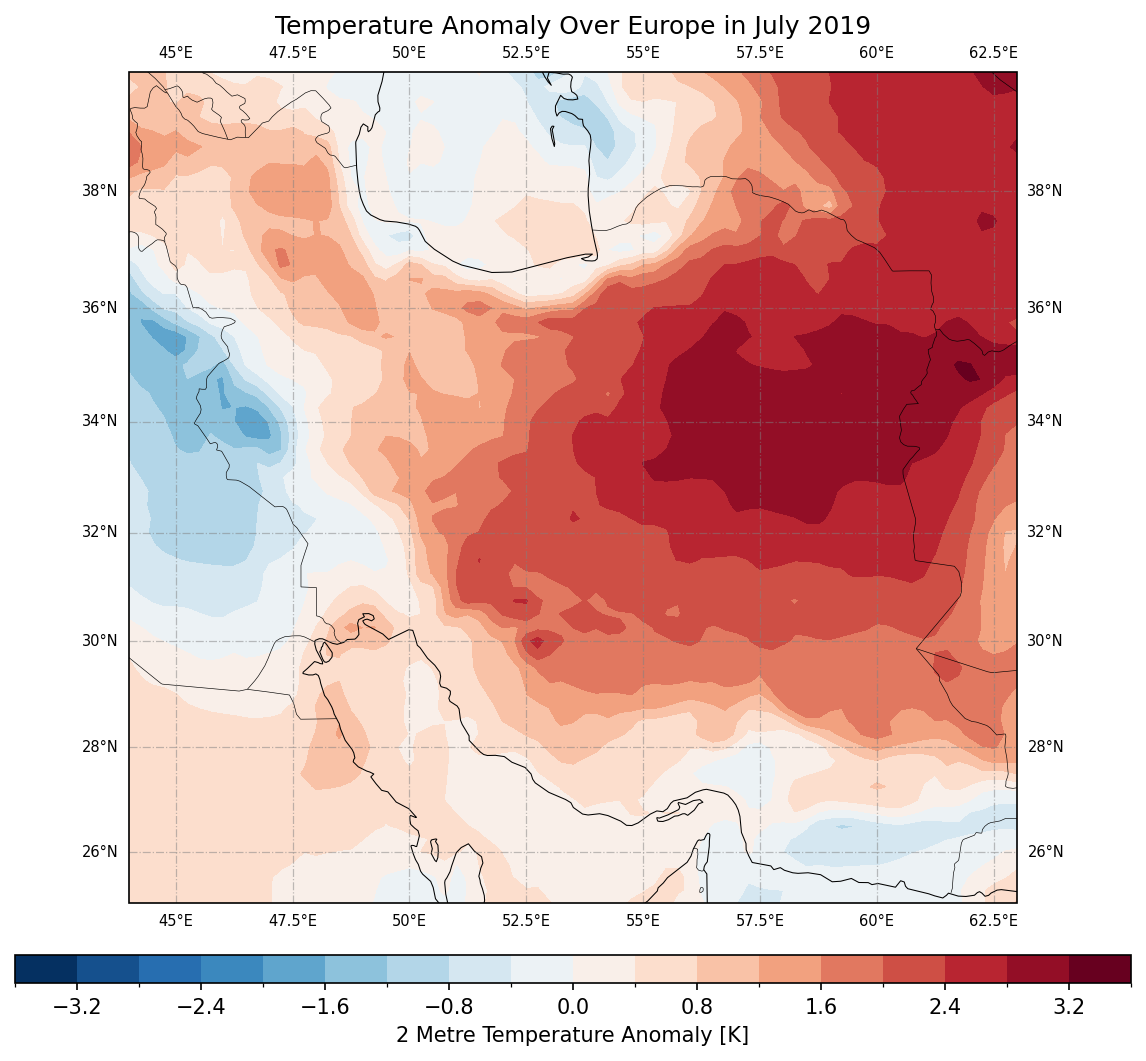

In [8]:
# Create copy of the data so we maintain original data
cropped_dataset = deepcopy(original_data) 
cropped_dataset = cropped_dataset.sel(
        latitude=slice(lat_max, lat_min), 
        longitude=slice(lon_min, lon_max)
    )
plot_dataset(cropped_dataset)

/tmp/ipykernel_1141520/3771848822.py:22: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop(lon_name)


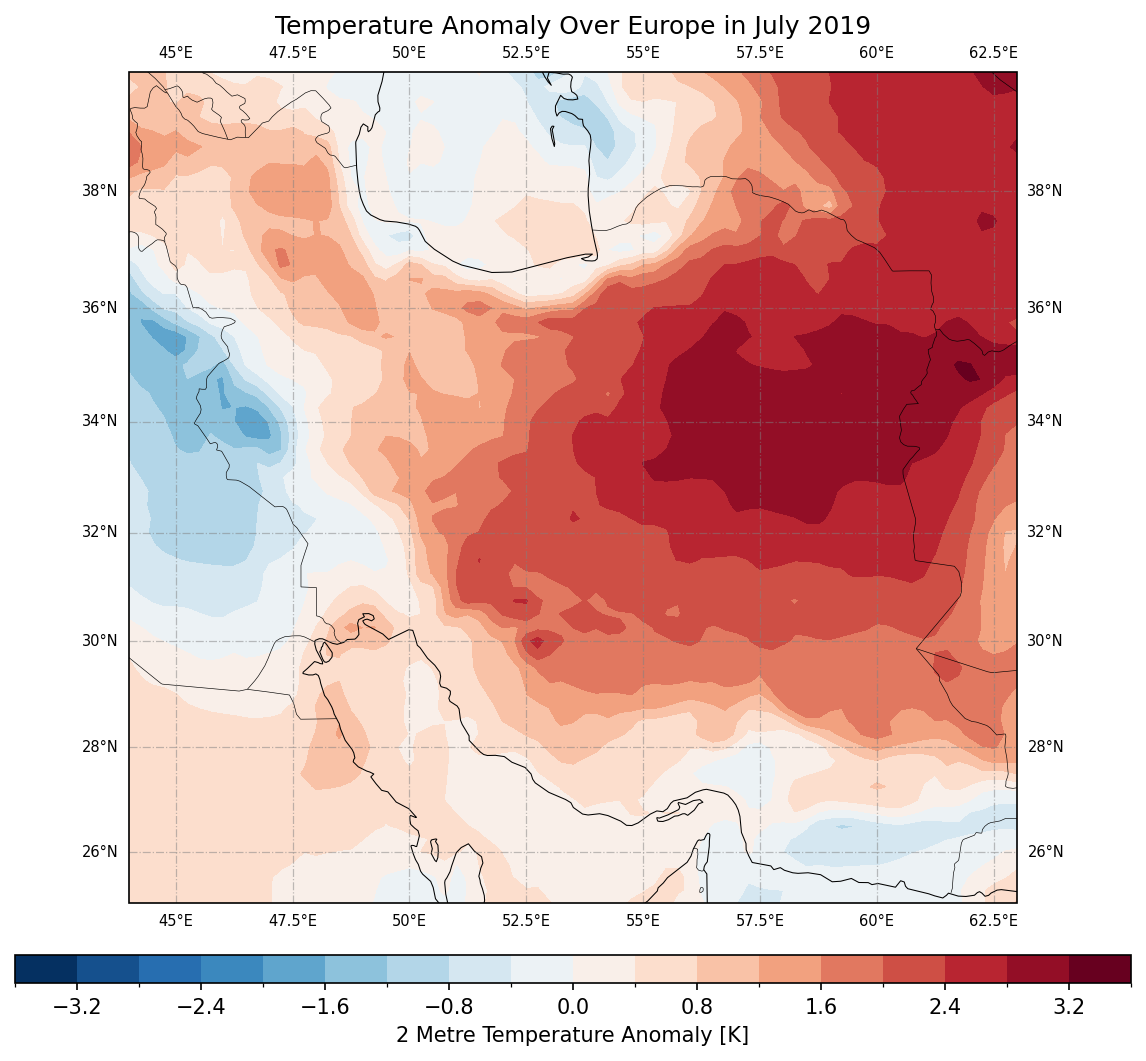

In [9]:

# Create copy of the data so we maintain original data
cropped_dataset = deepcopy(original_data) 

def adjust_longitude(dataset: xr.Dataset) -> xr.Dataset:
        """Swaps longitude coordinates from range (0, 360) to (-180, 180)

        Args:
            dataset (xr.Dataset): xarray Dataset

        Returns:
            xr.Dataset: xarray Dataset with swapped longitude dimensions
        """
        lon_name = "longitude"  # whatever name is in the data

        # Adjust lon values to make sure they are within (-180, 180)
        dataset["_longitude_adjusted"] = xr.where(
            dataset[lon_name] > 180, dataset[lon_name] - 360, dataset[lon_name]
        )
        dataset = (
            dataset.swap_dims({lon_name: "_longitude_adjusted"})
            .sel(**{"_longitude_adjusted": sorted(dataset._longitude_adjusted)})
            .drop(lon_name)
        )

        dataset = dataset.rename({"_longitude_adjusted": lon_name})
        return dataset

cropped_dataset = adjust_longitude(cropped_dataset)

cropped_dataset = cropped_dataset.sel(
        latitude=slice(lat_max, lat_min), 
        longitude=slice(lon_min, lon_max)
    )

plot_dataset(cropped_dataset)